In [ ]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

100%|██████████| 26421880/26421880 [00:07<00:00, 3440030.05it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 308759.31it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5497719.60it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5348594.75it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   t10k-labels-idx1-ubyte.gz   train-labels-idx1-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte     train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte	   train-images-idx3-ubyte.gz


In [ ]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):
        if train:
            images, labels = load_mnist(os.path.join(path,"raw"))
        else:
            images, labels = load_mnist(os.path.join(path,"raw"), kind="t10k")
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.images = np.reshape(np.array(images, dtype = np.float64),(-1,28,28))
        self.labels = np.array(labels, dtype = np.int64)

    def __len__(self,):
        length = len(self.images)
        return length

    def __getitem__(self, idx):
        img = self.images[idx]
        label = np.array(self.labels[idx])
        if(self.image_transform is not None):
          img = self.image_transform(img)
        if(self.label_transform is not None):
          label = self.label_transform(label)
        return img, label


In [ ]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

In [ ]:
test_dataset.__len__()

10000

In [ ]:
img, lbl = test_dataset.__getitem__(0)
print(img.shape, lbl.shape)
print(img.dtype,lbl.dtype)

(28, 28) ()
float64 int64


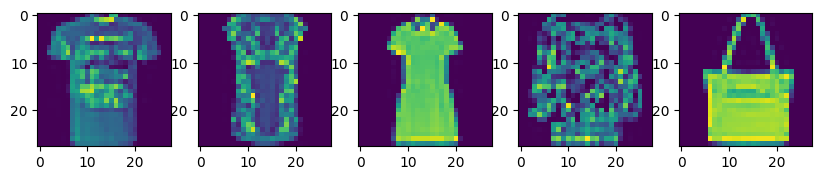

In [ ]:


indicies = np.random.choice(train_dataset.__len__(), 5)
imgs, lbls = train_dataset.__getitem__(indicies)


fig, axs = plt.subplots(1, len(imgs), figsize = (10,10))
for i in range(len(imgs)):
  axs[i].imshow(imgs[i])
plt.show()

In [ ]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample).to(torch.float64)

class ToTensor_Labels:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample).to(torch.int64)

In [ ]:
transform = ToTensor()
transfom_labels = ToTensor_Labels()

test_dataset = FashionMnist("data/FashionMNIST",
                            train=False,
                            image_transform=transform,
                            label_transform=transfom_labels
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=transform,
                             label_transform=transfom_labels
                             )

In [ ]:
print(f"The type of the data is {type(test_dataset[0][0])}")

The type of the data is <class 'torch.Tensor'>


In [ ]:
img, lbl = test_dataset.__getitem__(0)
print(img.shape, lbl.shape)
print(img.dtype,lbl.dtype)

torch.Size([28, 28]) torch.Size([])
torch.float64 torch.int64


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [ ]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")
print(f"The shape of the batch[1] is {batch[1].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])
The shape of the batch[1] is torch.Size([15])


In [ ]:
def collate(batch):
    imgs, labels = zip(*batch)
    imgs = torch.stack(imgs)
    labels = torch.LongTensor(labels)

    return imgs, labels

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=2,
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=2,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

In [ ]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")
print(f"The shape of the batch[1] is {batch[1].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([32, 28, 28])
The shape of the batch[1] is torch.Size([32])


In [ ]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

In [ ]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)

In [ ]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = input.clone()
        out[out < 0] = 0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        (input,) = ctx.saved_tensors
        out = input.clone()
        out[out > 0] = 1
        out[out <= 0] = 0
        return out*grad_output


In [ ]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()


    def forward(self, input):
        return ReLUFunction.apply(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [ ]:

x = (torch.randn(10, 5, requires_grad=True, dtype=torch.float64),)
relu = ReLU()
assert gradcheck(relu, x)

In [1]:

torch_relu = nn.functional.relu
our_relu = ReLU()
# Создаем случайный тензор
x = torch.randn(10, 5)
assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

NameError: name 'nn' is not defined

In [ ]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):
        ctx.save_for_backward(inp,weight,bias)
        output =  inp @ weight.T
        if(bias is not None):
          output.add_(bias)
        return output
    @staticmethod
    def backward(ctx, grad_output):
        (inp,weight,bias,) = ctx.saved_tensors
        grad_input = grad_output @ weight
        grad_weight = grad_output.T @ inp
        if(bias is not None):
          grad_bias = grad_output.sum(0)
        return grad_input, grad_weight, grad_bias

In [ ]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()
        self.input_units = input_units
        self.output_units = output_units
        self.weight =nn.Parameter(torch.randn(output_units, input_units, dtype = torch.float64))
        self.bias = nn.Parameter(torch.zeros(output_units, dtype = torch.float64))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=1)
        nn.init.zeros_(self.bias)

    def forward(self,inp):
        return LinearFunction.apply(inp,self.weight, self.bias)

In [ ]:
x = (torch.randn(1,5, requires_grad=True, dtype=torch.float64),)
linear = Linear(5,10)
assert gradcheck(linear, x)

In [ ]:
weight = torch.randn(10,5, requires_grad=True, dtype=torch.float64)
bias = torch.randn(10, requires_grad=True, dtype=torch.float64)

torch_linear = nn.Linear(5,10,dtype=torch.float64)
our_linear = Linear(5,10)

state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)

input_data = torch.randn(1,5, requires_grad=True, dtype=torch.float64)
torch_output = torch_linear(input_data)
our_output = our_linear(input_data)
print("Выходы идентичны?", torch.allclose(torch_output, our_output))

print("Веса идентичны?", torch.allclose(torch_linear.weight, our_linear.weight))
print("Смещения идентичны?", torch.allclose(torch_linear.bias, our_linear.bias))

Выходы идентичны? True
Веса идентичны? True
Смещения идентичны? True


In [ ]:
class LogSoftmaxFunction(Function):
    @staticmethod
    def forward(ctx, inp):
        mx,_ = torch.max(inp,dim = 1, keepdim=True)
        exp = torch.exp(inp - mx)
        ctx.save_for_backward(exp)
        lse = mx + torch.log(torch.sum(exp, dim = 1, keepdim=True))
        return inp - lse

    @staticmethod
    def backward(ctx, grad_output):
        (exp,) = ctx.saved_tensors
        softmax = exp / exp.sum(dim=1, keepdim=True)
        return grad_output - grad_output.sum(dim=1, keepdim=True) * softmax

In [ ]:
class LogSoftmax(nn.Module):
    def __init__(self):
        super().__init__()


    def forward(self, input):

        return LogSoftmaxFunction.apply(input)

In [ ]:

x = torch.randn(5,4, requires_grad=True, dtype=torch.float64)

lgsft = LogSoftmax()
assert gradcheck(lgsft, x)

In [ ]:
class DropoutFunction(Function):
    @staticmethod
    def forward(ctx, inp, p):

        mask = (torch.rand_like(inp) > p).double()
        ctx.save_for_backward(mask)
        return inp * mask
    @staticmethod
    def backward(ctx, grad_output):
        (mask,) = ctx.saved_tensors
        return grad_output * mask, None

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p

    def forward(self, input):
        return DropoutFunction.apply(input,self.p)

In [ ]:
class CrossEntropyFunction(Function):
    @staticmethod
    def forward(ctx, activations, target):
        ctx.save_for_backward(activations,target)
        return -activations[torch.arange(len(target)), target].sum()


    @staticmethod
    def backward(ctx, grad_output):
        (activations,target) = ctx.saved_tensors
        loss_grad = torch.zeros_like(activations)
        loss_grad[torch.arange(len(target)), target] = -1
        return grad_output*loss_grad, None

class CrossEntropy(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, activations, target):
        return CrossEntropyFunction.apply(activations, target)

In [ ]:

batch_size = 3
num_classes = 2
x = torch.randn(batch_size, num_classes, requires_grad=True, dtype=torch.float64)
t = torch.randint(0, num_classes, (batch_size,))
crs = CrossEntropy()
assert gradcheck(crs, (x, t,))

In [ ]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(*(
            [Linear(input_size, hidden_layers_size), ReLU()] +
            [Linear(hidden_layers_size, hidden_layers_size), ReLU(), Dropout(0.1)] * (num_layers - 2) +
            [Linear(hidden_layers_size, num_classes)]
        ))
        self.logsoftmax = LogSoftmax()


    def forward(self, inp):
        out = self.flatten(inp)
        out = self.layers(out)
        out = self.logsoftmax(out)
        return out
    def predict(self, inp):
        out = self.flatten(inp)
        out = self.layers(out)
        out = self.logsoftmax(out)
        mx, mx_ind = torch.max(out, dim = 1)
        return mx_ind

In [ ]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [3]:
def accuracy(model_labels, labels):
  return torch.mean((model_labels == labels).float())

In [ ]:
def perform_epoch(model, loader, criterion,
                optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            model_labels = model(batch_data)
            model_prediction = model.predict(batch_data)
            new_loss = criterion(model_labels, batch_labels)
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              optimizer.step()

            one_batch_loss = float(criterion(model_labels, batch_labels))
            one_batch_acc = accuracy(model_prediction, batch_labels)

            total_loss += one_batch_loss
            total_acc += one_batch_acc
            total_n += 1
    return (total_loss / total_n, total_acc / total_n)

In [ ]:
model = Network()
optimizer = Adam(model.parameters(), lr = 0.001)
criterion = CrossEntropy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 51.6342622397966, accuracy 0.38420000672340393
Current learning rate: 0.001
Epoch - 1 : loss 39.57963521012532, accuracy 0.46031665802001953
Current learning rate: 0.001
Epoch - 2 : loss 34.06419314783473, accuracy 0.5390333533287048
Current learning rate: 0.001
Epoch - 3 : loss 29.57869427229736, accuracy 0.6063166856765747
Current learning rate: 0.001
Epoch - 4 : loss 26.652763603944333, accuracy 0.6557666659355164
Current learning rate: 0.001
Epoch - 5 : loss 25.75914193734647, accuracy 0.6623499989509583
Current learning rate: 0.001
Epoch - 6 : loss 24.91284801438434, accuracy 0.6769333481788635
Current learning rate: 0.001
Epoch - 7 : loss 24.61832833999437, accuracy 0.6821500062942505
Current learning rate: 0.001
Epoch - 8 : loss 23.72726201168005, accuracy 0.7053999900817871
Current learning rate: 0.001
Epoch - 9 : loss 21.46915428641519, accuracy 0.7492333054542542
Current learning rate: 0.001


In [ ]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 21.46915428641519, accuracy 0.7492333054542542
Current learning rate: 0.001


In [ ]:
loss, acc = perform_epoch(model, test_dataloader, criterion,
                                device=device)
print(f"loss_test {loss}, accuracy_test {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

loss_test 23.24484013426902, accuracy_test 0.732627809047699
Current learning rate: 0.001


Почему-то с Dropout качество проседает. Попробуем без него

In [ ]:
class Network_without_Dropout(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(*(
            [Linear(input_size, hidden_layers_size), ReLU()] +
            [Linear(hidden_layers_size, hidden_layers_size), ReLU()] * (num_layers - 2) +
            [Linear(hidden_layers_size, num_classes)]
        ))
        self.logsoftmax = LogSoftmax()

    def forward(self, inp):

        out = self.flatten(inp)
        out = self.layers(out)
        out = self.logsoftmax(out)
        return out
    def predict(self, inp):

        out = self.flatten(inp)
        out = self.layers(out)
        out = self.logsoftmax(out)
        mx, mx_ind = torch.max(out, dim = 1)
        return mx_ind

In [ ]:
model = Network_without_Dropout()
optimizer = Adam(model.parameters(), lr = 0.001)
criterion = CrossEntropy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 29.404803132672072, accuracy 0.7129166722297668
Current learning rate: 0.001
Epoch - 1 : loss 17.21362648886538, accuracy 0.8064666390419006
Current learning rate: 0.001
Epoch - 2 : loss 15.275625302131816, accuracy 0.8295166492462158
Current learning rate: 0.001
Epoch - 3 : loss 14.661084620667074, accuracy 0.8370833396911621
Current learning rate: 0.001
Epoch - 4 : loss 14.163717450038982, accuracy 0.8410833477973938
Current learning rate: 0.001
Epoch - 5 : loss 13.555657127089825, accuracy 0.847766637802124
Current learning rate: 0.001
Epoch - 6 : loss 13.233078924885337, accuracy 0.8519499897956848
Current learning rate: 0.001
Epoch - 7 : loss 12.874089018396413, accuracy 0.8552500009536743
Current learning rate: 0.001
Epoch - 8 : loss 12.878554439422947, accuracy 0.8547499775886536
Current learning rate: 0.001
Epoch - 9 : loss 12.408650572778626, accuracy 0.8588500022888184
Current learning rate: 0.001


In [ ]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 12.408650572778626, accuracy 0.8588500022888184
Current learning rate: 0.001


In [ ]:
loss, acc = perform_epoch(model, test_dataloader, criterion,
                                device=device)
print(f"loss_test {loss}, accuracy_test {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

loss_test 14.091739191765559, accuracy_test 0.8442491888999939
Current learning rate: 0.001


In [ ]:
layers_list = [3,5,7,9,11,12,15]
models = {}
models_test = {}
for num in layers_list:
  model = Network_without_Dropout(input_size=28*28, hidden_layers_size=32, num_layers=num,
                 num_classes=10)
  optimizer = Adam(model.parameters(), lr = 0.0001)
  criterion = CrossEntropy()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model.to(device)

  models[num] = []
  print(num)
  for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
    models[num].append((epoch,loss,acc))
  loss_t, acc_t = perform_epoch(model, test_dataloader, criterion,
                                device=device)
  models_test[num] = (loss_t, acc_t)

3
Epoch - 0 : loss 100.32534563943493, accuracy 0.5689666867256165
Current learning rate: 0.0001
Epoch - 1 : loss 28.18930789031394, accuracy 0.7028833627700806
Current learning rate: 0.0001
Epoch - 2 : loss 22.80952981178628, accuracy 0.7502666711807251
Current learning rate: 0.0001
Epoch - 3 : loss 20.14356842714954, accuracy 0.778083324432373
Current learning rate: 0.0001
Epoch - 4 : loss 18.435300669954206, accuracy 0.8004166483879089
Current learning rate: 0.0001
Epoch - 5 : loss 17.143671825946083, accuracy 0.8126999735832214
Current learning rate: 0.0001
Epoch - 6 : loss 16.16730251610894, accuracy 0.8218166828155518
Current learning rate: 0.0001
Epoch - 7 : loss 15.426716027964353, accuracy 0.8274999856948853
Current learning rate: 0.0001
Epoch - 8 : loss 14.86883645211721, accuracy 0.8331000208854675
Current learning rate: 0.0001
Epoch - 9 : loss 14.443990933303153, accuracy 0.8371999859809875
Current learning rate: 0.0001
5
Epoch - 0 : loss 66.00533428700008, accuracy 0.55615

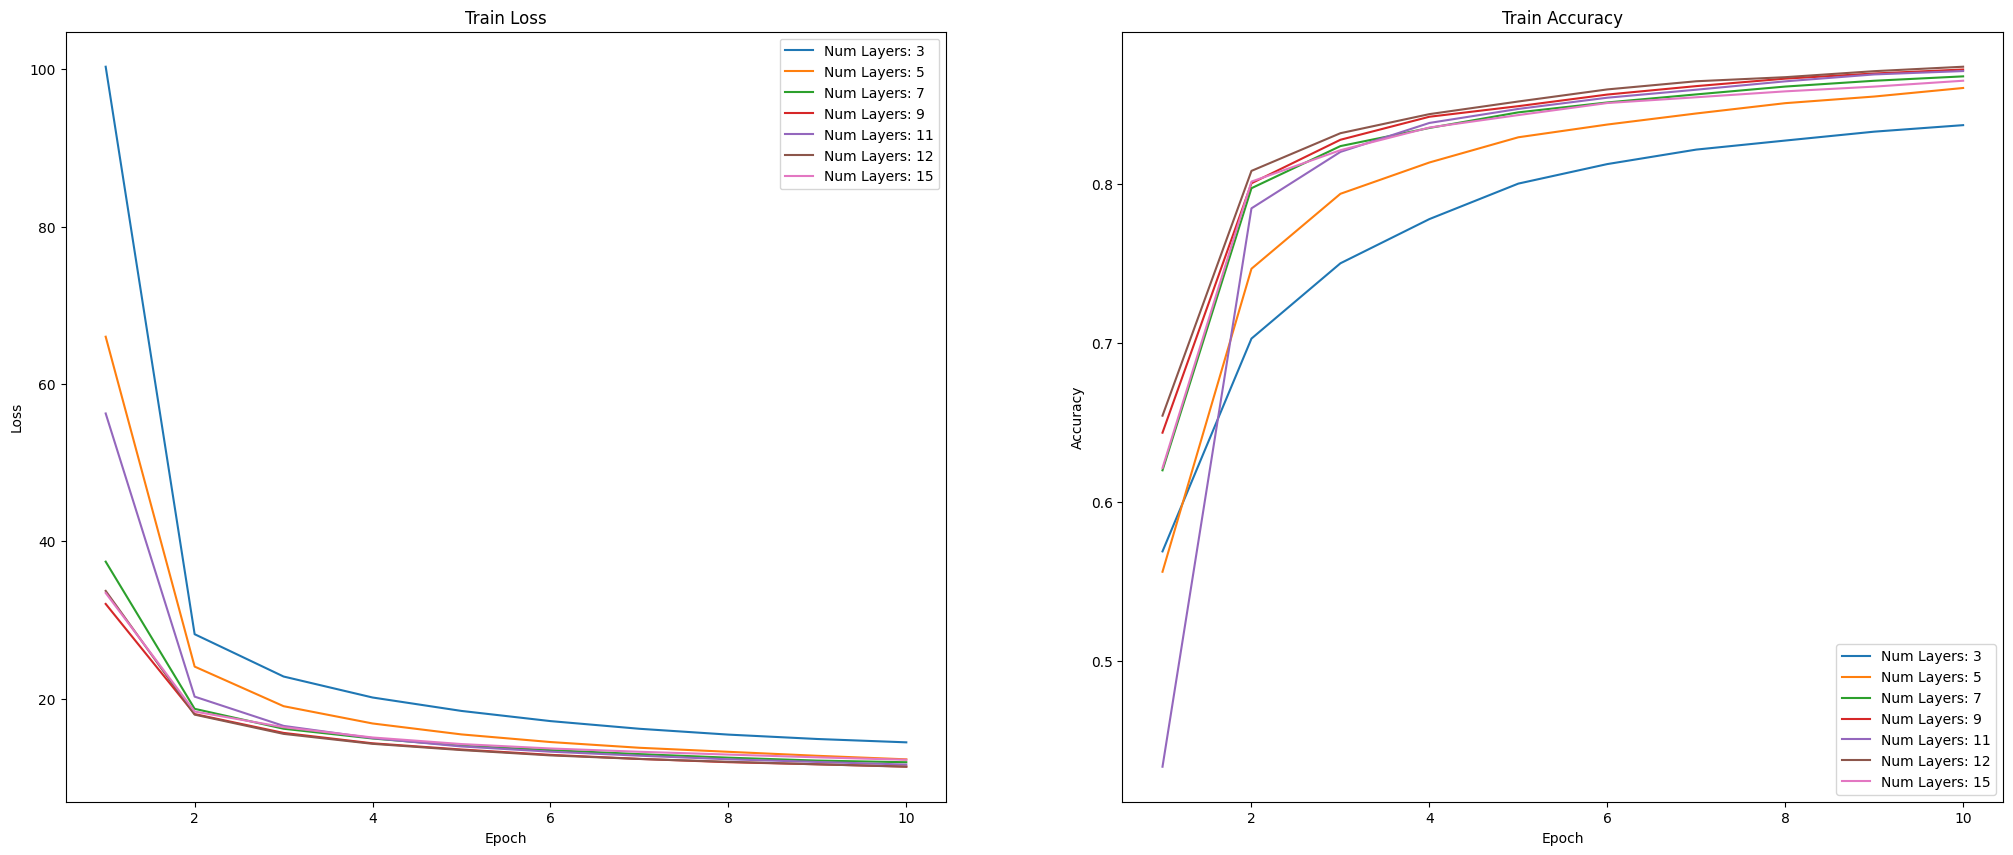

In [ ]:
test_acc = []
test_loss = []
epochs = np.arange(1,11)
fig, axes =  plt.subplots(1,2, figsize = (25,10))
for num in layers_list:
  acc_list = []
  loss_list = []
  for tup in models[num]:
    acc_list.append(tup[2])
    loss_list.append(tup[1])
  axes[0].plot(epochs, loss_list, label=f"Num Layers: {num}")
  axes[1].plot(epochs, acc_list, label=f"Num Layers: {num}")

  test_loss.append(models_test[num][0])
  test_acc.append(models_test[num][1])

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(loc="upper right")

axes[1].set_title("Train Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend(loc="lower right")
plt.show()

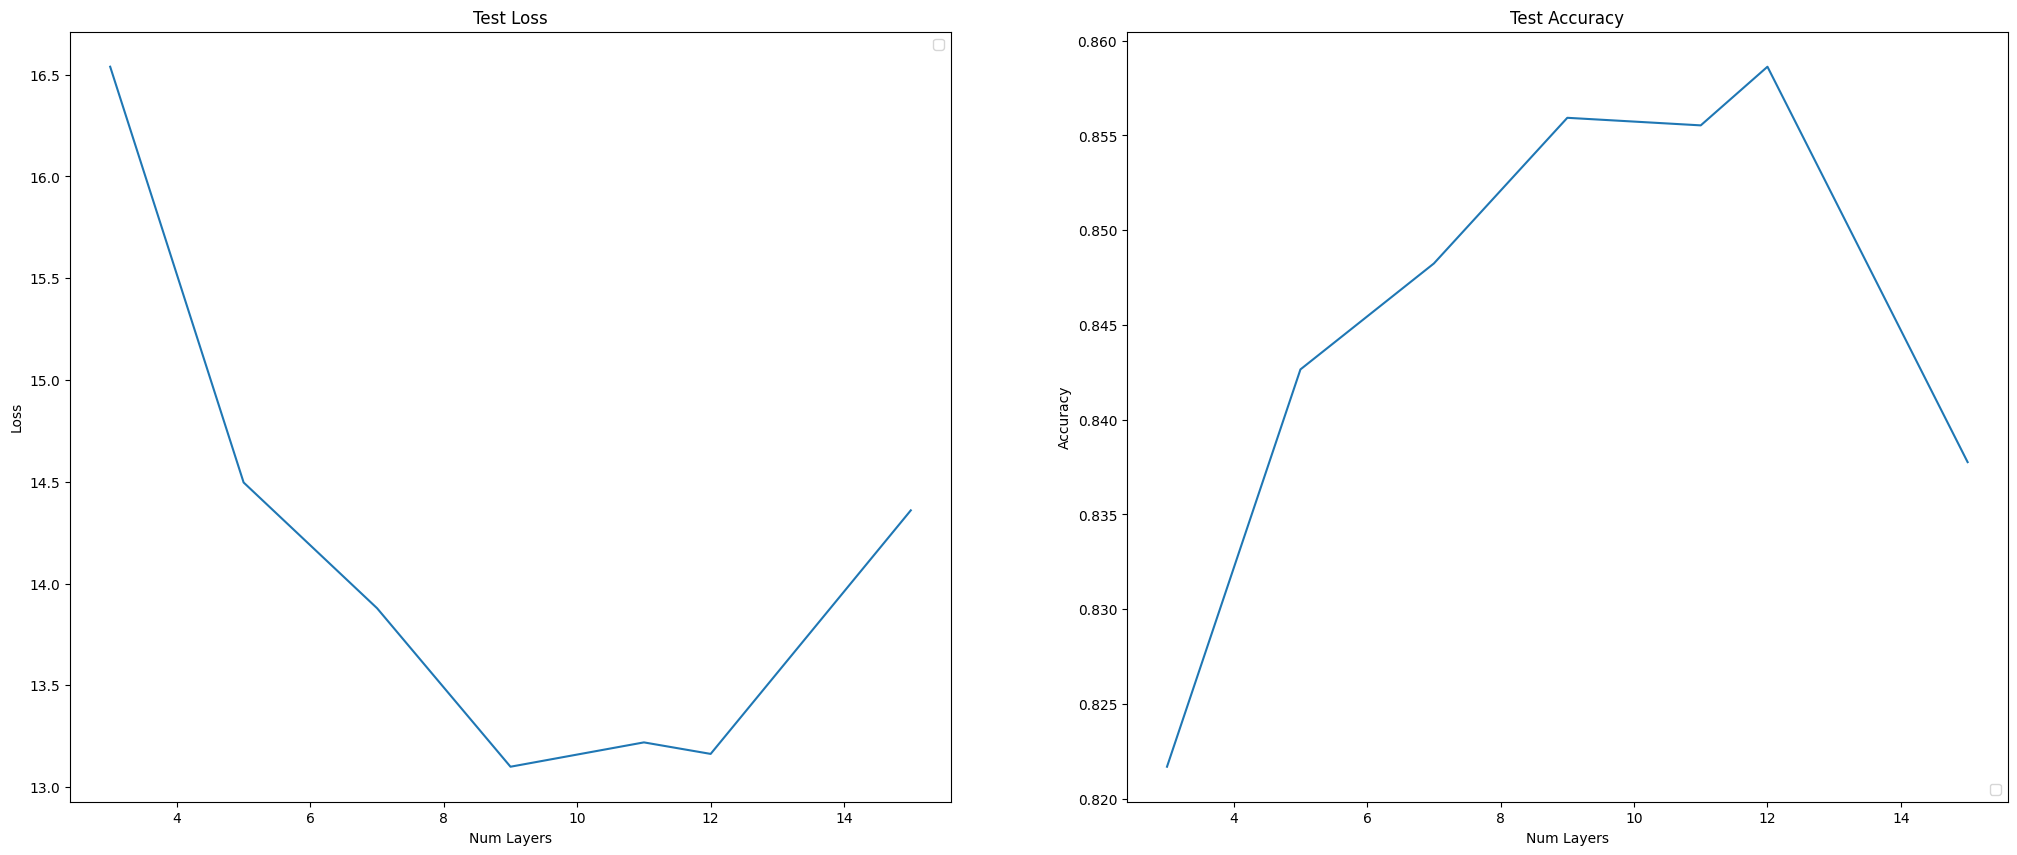

In [ ]:
fig, axes =  plt.subplots(1,2, figsize = (25,10))
axes[0].plot(layers_list,test_loss)
axes[1].plot(layers_list,test_acc)
axes[0].set_title("Test Loss")
axes[0].set_xlabel("Num Layers")
axes[0].set_ylabel("Loss")
axes[0].legend(loc="upper right")

axes[1].set_title("Test Accuracy")
axes[1].set_xlabel("Num Layers")
axes[1].set_ylabel("Accuracy")
axes[1].legend(loc="lower right")
plt.show()

# AngularGrad

Статья - https://arxiv.org/pdf/2105.10190

Особенности реализации подсмотрел тут - https://github.com/mhaut/AngularGrad/tree/main

In [ ]:
import math
class SotaOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(SotaOptimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SotaOptimizer, self).__setstate__(state)

    @torch.no_grad()
    def step(self,closure = None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            lr = group['lr']
            betas = group['betas']
            eps = group['eps']
            lamda1 = lambda2 = 0.5
            for p in group['params']:
                if p.grad is not None:
                    grad = p.grad.data
                else:
                    continue
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['last_grad'] = torch.zeros_like(p)
                    state['min'] = torch.zeros_like(p.data)
                    state['A_last'] = torch.zeros_like(p.data)
                    state['diff'] = torch.zeros_like(p.data)
                    state['f_theta'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq, last_grad, min, diff, f_theta, A_last = state['exp_avg'], state['exp_avg_sq'], \
                                                                                 state['last_grad'], state['min'], \
                                                                                 state['diff'], state['f_theta'], state['A_last']

                beta1, beta2 = betas
                state['step'] += 1


                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']


                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(eps)

                tan = abs((last_grad - grad) / (1 + last_grad * grad))


                angle = torch.atan(tan) * (180 / 3.141592653589793238)
                if(state['step'] == 1):
                  A_last = angle.clone()
                A = torch.min(A_last,angle)


                angular_coeff = torch.tanh(abs(A)) * lamda1 + lambda2

                state['last_grad'] = grad.clone()
                state['min'] = torch.min(angle,min)
                state['diff'] = diff.clone()
                state['f_theta'] = f_theta.clone()
                state['A_last'] = A.clone()

                exp_avg1 = exp_avg * angular_coeff

                step_size = lr * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg1, denom)

        return loss

In [ ]:
model = Network_without_Dropout()
optimizer = SotaOptimizer(model.parameters(), lr = 0.0001)
criterion = CrossEntropy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
sota_loss = []
sota_acc = []
for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    sota_loss.append(loss)
    sota_acc.append(acc)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 76.18626152237881, accuracy 0.5195000171661377
Current learning rate: 0.0001
Epoch - 1 : loss 27.57688764155309, accuracy 0.713100016117096
Current learning rate: 0.0001
Epoch - 2 : loss 21.69236020527552, accuracy 0.7663833498954773
Current learning rate: 0.0001
Epoch - 3 : loss 18.800910677413036, accuracy 0.7976999878883362
Current learning rate: 0.0001
Epoch - 4 : loss 17.060268202523044, accuracy 0.8141499757766724
Current learning rate: 0.0001
Epoch - 5 : loss 15.882830383643393, accuracy 0.8269000053405762
Current learning rate: 0.0001
Epoch - 6 : loss 15.024386485941468, accuracy 0.8344500064849854
Current learning rate: 0.0001
Epoch - 7 : loss 14.398671057226453, accuracy 0.8419666886329651
Current learning rate: 0.0001
Epoch - 8 : loss 13.944293324708383, accuracy 0.8464666604995728
Current learning rate: 0.0001
Epoch - 9 : loss 13.498020785443389, accuracy 0.8509666919708252
Current learning rate: 0.0001


In [ ]:
loss_test_s, acc_test_s = perform_epoch(model, test_dataloader, criterion,
                                device=device)
print(f"loss_test {loss}, accuracy_test {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

loss_test 13.498020785443389, accuracy_test 0.8509666919708252
Current learning rate: 0.0001


In [ ]:
model = Network_without_Dropout()
optimizer = Adam(model.parameters(), lr = 0.0001)
criterion = CrossEntropy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
adam_loss = []
adam_acc = []
for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    adam_loss.append(loss)
    adam_acc.append(acc)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 58.66985546693816, accuracy 0.5555166602134705
Current learning rate: 0.0001
Epoch - 1 : loss 24.565133527756416, accuracy 0.7442499995231628
Current learning rate: 0.0001
Epoch - 2 : loss 19.126177440742058, accuracy 0.7798833250999451
Current learning rate: 0.0001
Epoch - 3 : loss 17.12805987352688, accuracy 0.8066166639328003
Current learning rate: 0.0001
Epoch - 4 : loss 15.73269566955212, accuracy 0.8226333260536194
Current learning rate: 0.0001
Epoch - 5 : loss 14.666493260282088, accuracy 0.8329833149909973
Current learning rate: 0.0001
Epoch - 6 : loss 13.808451118795299, accuracy 0.8438166379928589
Current learning rate: 0.0001
Epoch - 7 : loss 13.200563345859345, accuracy 0.850849986076355
Current learning rate: 0.0001
Epoch - 8 : loss 12.78409419194624, accuracy 0.8557500243186951
Current learning rate: 0.0001
Epoch - 9 : loss 12.402780984262398, accuracy 0.8607500195503235
Current learning rate: 0.0001


In [ ]:
loss_test_a, acc_test_a = perform_epoch(model, test_dataloader, criterion,
                                device=device)
print(f"loss_test {loss}, accuracy_test {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

loss_test 12.402780984262398, accuracy_test 0.8607500195503235
Current learning rate: 0.0001


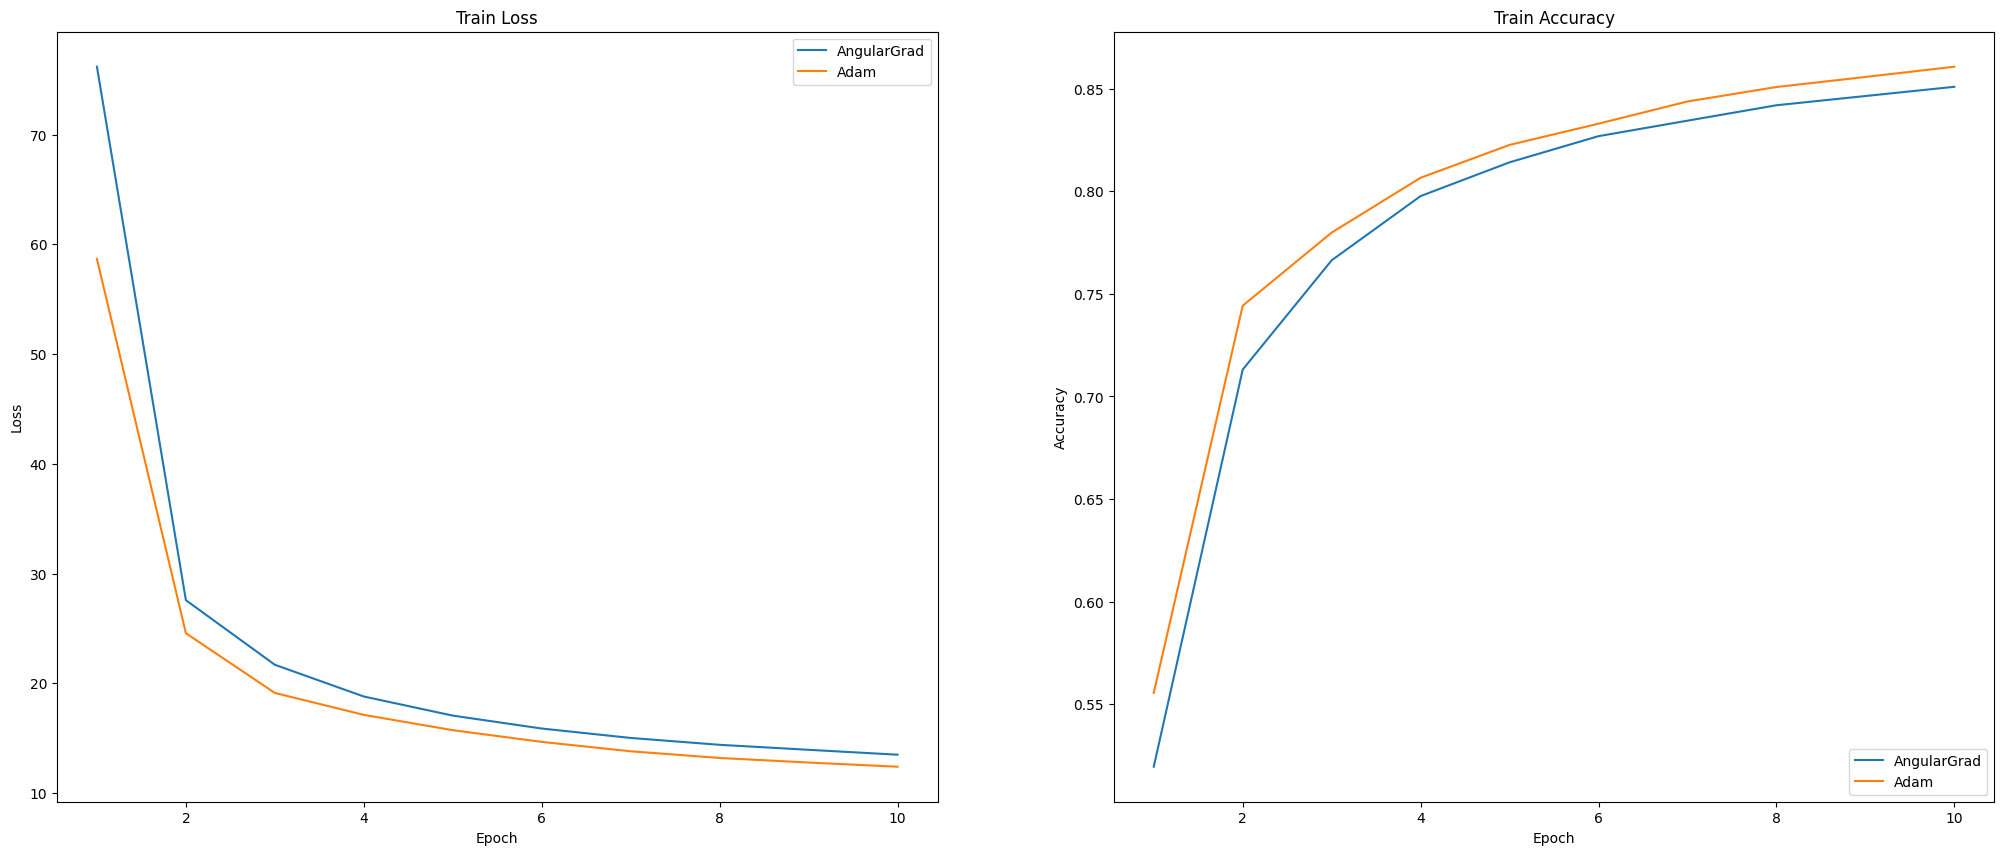

In [ ]:
fig, axes =  plt.subplots(1,2, figsize = (25,10))
epochs = np.arange(1,11)

axes[0].plot(epochs, sota_loss, label=f"AngularGrad")
axes[1].plot(epochs, sota_acc, label=f"AngularGrad")

axes[0].plot(epochs, adam_loss, label=f"Adam")
axes[1].plot(epochs, adam_acc, label=f"Adam")

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(loc="upper right")

axes[1].set_title("Train Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend(loc="lower right")

In [ ]:
print(f"loss_test Adam {loss_test_a}, accuracy_test Adam {acc_test_a}")
print(f"loss_test AngularGrad {loss_test_s}, accuracy_test AngularGrad {acc_test_s}")

loss_test Adam 14.514313083089686, accuracy_test Adam 0.8443490266799927
loss_test AngularGrad 15.984805133244842, accuracy_test AngularGrad 0.8328673839569092


В целом AngulaGrad работает не сильно хуже Adam. Были запуски, на которых он показывал лучшее качество

# Cauchy activation

Здесь рассматриваем функцию активации Коши в сравнении с кусочно-линейными ReLU и LeakyReLU

Статья - https://arxiv.org/pdf/2409.19221

In [ ]:
class Cauchy(nn.Module):
    def __init__(self, a=1.0, b=0.0, d=1.0):
        super(Cauchy, self).__init__()
        self.a = nn.Parameter(torch.tensor(a, dtype= torch.float64))
        self.b = nn.Parameter(torch.tensor(b, dtype= torch.float64))
        self.d = nn.Parameter(torch.tensor(d, dtype= torch.float64))

    def forward(self, x):
        return (self.a * x + self.b) / (x ** 2 + self.d ** 2)


In [ ]:
class LeakyReLU(nn.Module):
    def __init__(self, a=0.01):
        super().__init__()
        self.a = a

    def forward(self, x):
        return torch.max(x, self.a * x)

In [ ]:
class Network_Cauchy(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(*(
            [Linear(input_size, hidden_layers_size), Cauchy()] +
            [Linear(hidden_layers_size, hidden_layers_size), Cauchy()] * (num_layers - 2) +
            [Linear(hidden_layers_size, num_classes)]
        ))
        self.logsoftmax = LogSoftmax()

    def forward(self, inp):
        out = self.flatten(inp)
        out = self.layers(out)
        out = self.logsoftmax(out)
        return out
    def predict(self, inp):
        out = self.flatten(inp)
        out = self.layers(out)
        out = self.logsoftmax(out)
        mx, mx_ind = torch.max(out, dim = 1)
        return mx_ind


class Network_LeakyReLU(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(*(
            [Linear(input_size, hidden_layers_size), LeakyReLU()] +
            [Linear(hidden_layers_size, hidden_layers_size), LeakyReLU()] * (num_layers - 2) +
            [Linear(hidden_layers_size, num_classes)]
        ))
        self.logsoftmax = LogSoftmax()


    def forward(self, inp):
        out = self.flatten(inp)
        out = self.layers(out)
        out = self.logsoftmax(out)
        return out
    def predict(self, inp):
        out = self.flatten(inp)
        out = self.layers(out)
        out = self.logsoftmax(out)
        mx, mx_ind = torch.max(out, dim = 1)
        return mx_ind

In [ ]:
model = Network_LeakyReLU()
optimizer = Adam(model.parameters(), lr = 0.001)
criterion = CrossEntropy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
LeakyReLU_loss = []
LeakyReLU_acc = []
for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    LeakyReLU_loss.append(loss)
    LeakyReLU_acc.append(acc)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 31.726254356555273, accuracy 0.7264833450317383
Current learning rate: 0.001
Epoch - 1 : loss 17.574131483571456, accuracy 0.8120499849319458
Current learning rate: 0.001
Epoch - 2 : loss 15.699106915711369, accuracy 0.8282166719436646
Current learning rate: 0.001
Epoch - 3 : loss 14.648910469284159, accuracy 0.8392166495323181
Current learning rate: 0.001
Epoch - 4 : loss 13.862236352251582, accuracy 0.8451333045959473
Current learning rate: 0.001
Epoch - 5 : loss 13.31925989432482, accuracy 0.8510000109672546
Current learning rate: 0.001
Epoch - 6 : loss 12.799859542038936, accuracy 0.856166660785675
Current learning rate: 0.001
Epoch - 7 : loss 12.582598718390193, accuracy 0.8581333160400391
Current learning rate: 0.001
Epoch - 8 : loss 12.200959141864205, accuracy 0.8618833422660828
Current learning rate: 0.001
Epoch - 9 : loss 11.889867162699842, accuracy 0.8658000230789185
Current learning rate: 0.001


In [ ]:
loss_test_l, acc_test_l = perform_epoch(model, test_dataloader, criterion,
                                device=device)
print(f"loss_test {loss_test_l}, accuracy_test {acc_test_l}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

loss_test 12.830640224702172, accuracy_test 0.8607228398323059
Current learning rate: 0.001


In [ ]:
model = Network_Cauchy()
optimizer = Adam(model.parameters(), lr = 0.001)
criterion = CrossEntropy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
Cauchy_loss = []
Cauchy_acc = []
for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    Cauchy_loss.append(loss)
    Cauchy_acc.append(acc)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 70.8328399823165, accuracy 0.16486667096614838
Current learning rate: 0.001
Epoch - 1 : loss 51.29788216658961, accuracy 0.3930833339691162
Current learning rate: 0.001
Epoch - 2 : loss 46.87794993283721, accuracy 0.4409833252429962
Current learning rate: 0.001
Epoch - 3 : loss 44.714896190876026, accuracy 0.4734833240509033
Current learning rate: 0.001
Epoch - 4 : loss 38.227103436097046, accuracy 0.5610166788101196
Current learning rate: 0.001
Epoch - 5 : loss 48.21627379988796, accuracy 0.46381667256355286
Current learning rate: 0.001
Epoch - 6 : loss 42.32066697089332, accuracy 0.5249166488647461
Current learning rate: 0.001


KeyboardInterrupt: 

In [ ]:
loss_test_c, acc_test_c = perform_epoch(model, test_dataloader, criterion,
                                device=device)
print(f"loss_test {loss_test_c}, accuracy_test {acc_test_c}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

loss_test 42.11963409280105, accuracy_test 0.5260583162307739
Current learning rate: 0.001


In [ ]:
model = Network_without_Dropout()
optimizer = Adam(model.parameters(), lr = 0.001)
criterion = CrossEntropy()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
ReLU_loss = []
ReLU_acc = []
for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion,
                                optimizer=optimizer, device=device)
    ReLU_loss.append(loss)
    ReLU_acc.append(acc)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 28.568783266035524, accuracy 0.7396833300590515
Current learning rate: 0.001
Epoch - 1 : loss 16.28316603136362, accuracy 0.8198999762535095
Current learning rate: 0.001
Epoch - 2 : loss 14.928399759343531, accuracy 0.8341333270072937
Current learning rate: 0.001
Epoch - 3 : loss 13.838730168073837, accuracy 0.845716655254364
Current learning rate: 0.001
Epoch - 4 : loss 13.223395145827723, accuracy 0.8513000011444092
Current learning rate: 0.001
Epoch - 5 : loss 12.86255978729496, accuracy 0.855400025844574
Current learning rate: 0.001
Epoch - 6 : loss 12.54129919083684, accuracy 0.8569499850273132
Current learning rate: 0.001
Epoch - 7 : loss 12.26309604036836, accuracy 0.8598166704177856
Current learning rate: 0.001
Epoch - 8 : loss 12.0691018870864, accuracy 0.8632166385650635
Current learning rate: 0.001
Epoch - 9 : loss 11.755158860295847, accuracy 0.866349995136261
Current learning rate: 0.001


In [ ]:
loss_test_r, acc_test_r = perform_epoch(model, test_dataloader, criterion,
                                device=device)
print(f"loss_test {loss_test_r}, accuracy_test {acc_test_r}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

loss_test 14.827898275021136, accuracy_test 0.8294728398323059
Current learning rate: 0.001


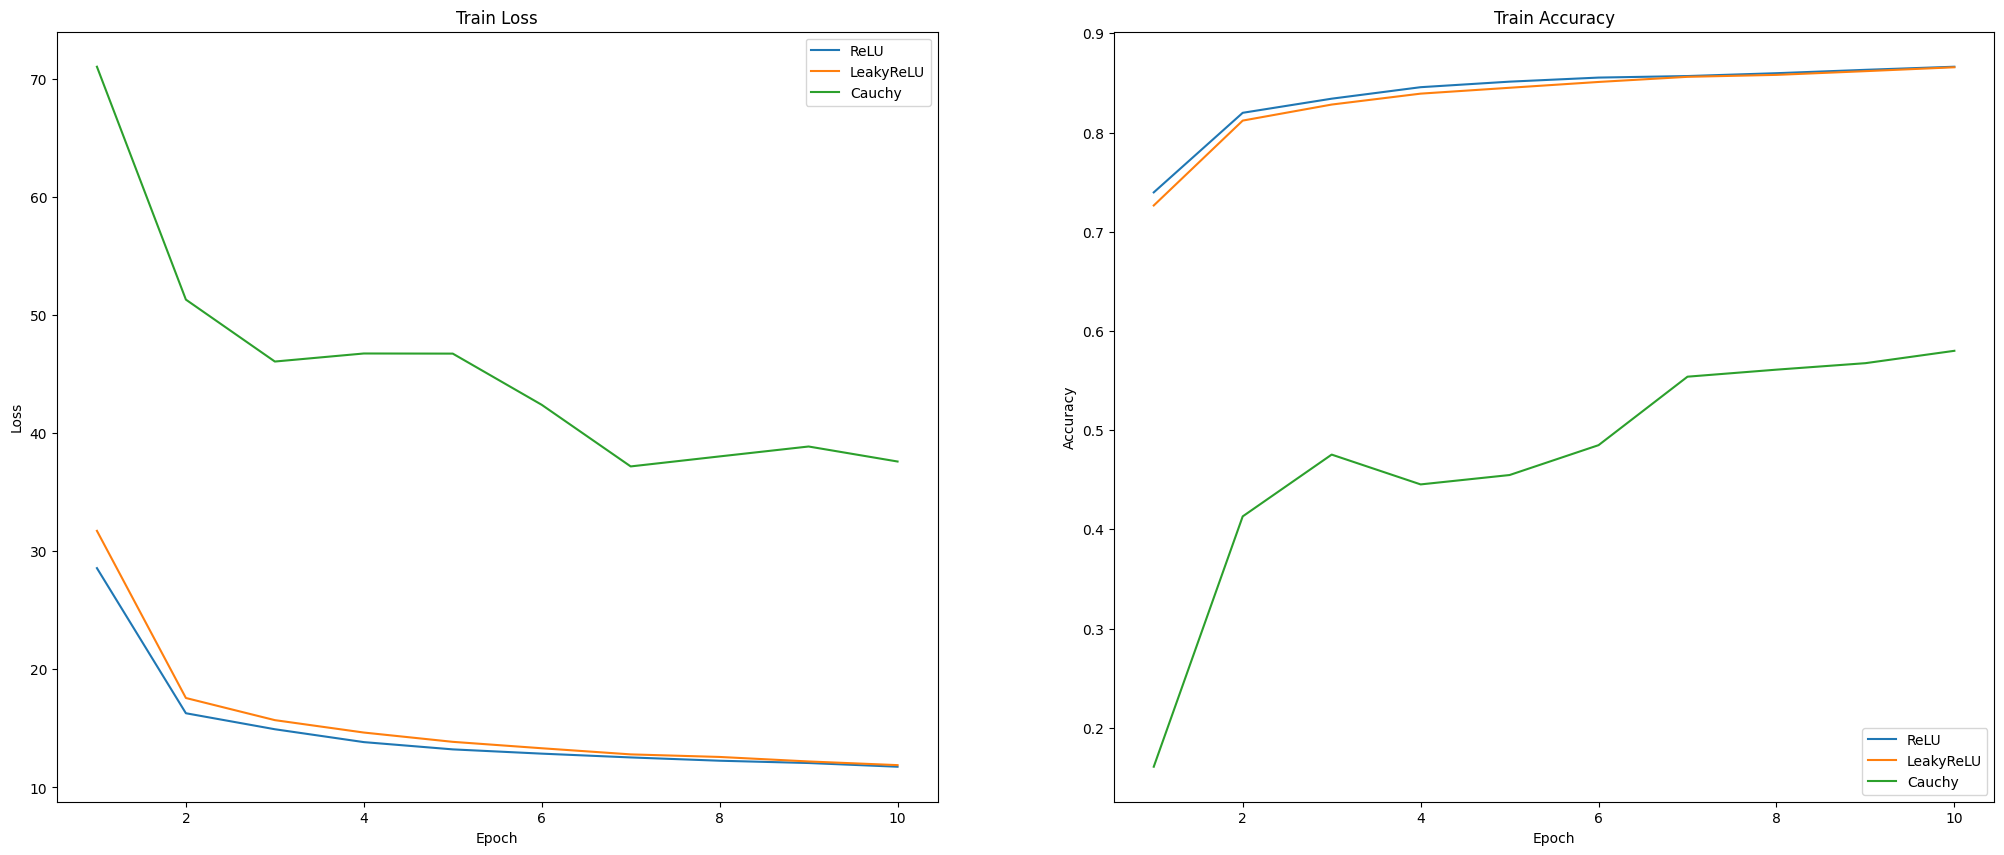

In [ ]:
fig, axes =  plt.subplots(1,2, figsize = (25,10))
epochs = np.arange(1,11)

axes[0].plot(epochs, ReLU_loss, label=f"ReLU")
axes[1].plot(epochs, ReLU_acc, label=f"ReLU")

axes[0].plot(epochs, LeakyReLU_loss, label=f"LeakyReLU")
axes[1].plot(epochs, LeakyReLU_acc, label=f"LeakyReLU")

axes[0].plot(epochs, Cauchy_loss, label=f"Cauchy")
axes[1].plot(epochs, Cauchy_acc, label=f"Cauchy")

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(loc="upper right")

axes[1].set_title("Train Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend(loc="lower right")

In [ ]:
print(f"loss_test ReLU {loss_test_r}, accuracy_test ReLU {acc_test_r}")
print(f"loss_test LeakyReLU {loss_test_l}, accuracy_test LeakyReLU {acc_test_l}")
print(f"loss_test Cauchy {loss_test_c}, accuracy_test Cauchy {acc_test_c}")

loss_test ReLU 14.827898275021136, accuracy_test ReLU 0.8294728398323059
loss_test LeakyReLU 12.830640224702172, accuracy_test LeakyReLU 0.8607228398323059
loss_test Cauchy 42.11963409280105, accuracy_test Cauchy 0.5260583162307739


Коши показывает худшие результаты. Она лучше подходит для физических задач при приближении бесконечно гладких функций(Статья). А вот LeakyReLU справился лучше всех.